*dand p3 project report*
# Data Wrangling with python & MongoDB

Cao Zhihua    
2016-12-26

### 地图／Map Area : <span style='color:blue'>Dresden, Germany</span>
**Size:** 315.5M (uncompressed)    
**Source:** [Map Zen](https://mapzen.com)     
**Download Link:** https://s3.amazonaws.com/metro-extracts.mapzen.com/dresden_germany.osm.bz2     
**Reason of choice**: 曾经出差访问过德国的Dresden，印象不错，加上会一些德语，有助于处理地图中的德语信息。

## 1. 数据分析

### 数据问题综述
<span style='color:blue'>通过对样本和完整数据集的探索，发现该数据集总体上数据质量还是相当不错的，但仍有以下几点问题需要在导入数据库前予以处理：
1. tag元素中，有小部分的k值中使用了非标的"."符号而非标准的":"符号。
2. 有部分tag元素通过特殊k值"FIXME"标注为存疑或者待完善，无须倒入数据库中。
3. 部分数据为目标城市周边地区的信息，需要予以剔除。
4. 德语中半元音(ä,ö,ü等）可能需要进行编码处理才能顺利导入mongoDB。

<span style='color:blue'>下面就发现这些问题的具体过程和步骤进行详细说明：</span>

### 数据探索过程说明

首先通过课程提供的代码（如下）从完整数据文件中提取出取样数据文件(k=50)：    
    <span style='color:blue'>dresden-sample.osm --------  6.6M</span>    

In [296]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

#import xml.etree.ElementTree as ET  # Use cElementTree or lxml if too slow
import xml.etree.cElementTree as ET

OSM_FILE = "dresden_germany.osm"
SAMPLE_FILE = "dresden-sample.osm"

k = 50

def get_element(osm_file, tags=('node', 'way', 'relation')):
    context = iter(ET.iterparse(osm_file, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


with open(SAMPLE_FILE, 'wb') as output:
    output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write('<osm>\n  ')

    # Write every kth top level element
    for i, element in enumerate(get_element(OSM_FILE)):
        if i % k == 0:
            output.write(ET.tostring(element, encoding='utf-8'))

    output.write('</osm>')

探究sample文件中的标签种类和数量

In [297]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import xml.etree.cElementTree as ET
import pprint

def count_tags(filename):
    tags = {}
    for event, elem in ET.iterparse(filename):
        if elem.tag in tags:
            tags[elem.tag] += 1
        else:
            tags[elem.tag] = 1
            
    return tags

def test():

    tags = count_tags('dresden-sample.osm')
    pprint.pprint(tags)
    
if __name__ == "__main__":
    test()

{'member': 1735,
 'nd': 33028,
 'node': 25557,
 'osm': 1,
 'relation': 88,
 'tag': 24893,
 'way': 4727}


接下来对tag标签下面的k值进行探索

In [298]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import xml.etree.cElementTree as ET
import pprint

def count_tags(filename):
    tags_k = {}
    for event, elem in ET.iterparse(filename):
        if elem.tag == 'tag':
            tags_k[elem.get('k').strip()] = tags_k.get(elem.get('k').strip(), 0) + 1
            
    return tags_k

tags_k = count_tags('dresden-sample.osm')

In [299]:
def sort_dict(mydict):
    return mydict[1]
pprint.pprint(sorted(tags_k.iteritems(), key=sort_dict, reverse=False)[:10])
print ' ...'

[('motorhome', 1),
 ('class:bicycle', 1),
 ('bicycle:lanes:backward', 1),
 ('seamark:beacon_lateral:colour_pattern', 1),
 ('max_age', 1),
 ('fenced', 1),
 ('denomination:de', 1),
 ('recycling:magazines', 1),
 ('facebook', 1),
 ('cn_ukd:token', 1)]
 ...


以上代码对个标签的k值出现次数进行了倒排序，可以看到有很多k值只出现过1次，再看看这些出现一次的tag k值对应的v值：

In [300]:
def audit_tags(filename, tags_k):
    n = 10
    for event, elem in ET.iterparse(filename):
        if elem.tag == 'tag':
            if tags_k[elem.get('k').strip()] <= 1: 
                print elem.get('k'), '|', elem.get('v')
                n = n - 1
        if n == 0:
            break
audit_tags('dresden-sample.osm', tags_k)

ref:isil | DE-106
seamark:small_craft_facility:category | slipway
source:ref | interpolation
asb | 261
onkz | 351
note:de | http://wiki.openstreetmap.org/index.php/DE:DSL_Hauptverteiler
fee_zone | 70
theatre:genre | circus
temporary:date_on | 2015-11-17
temporary:date_off | 2016-02-14


以上可以看出，即使值出现一次，数据质量问题不大。    
接下来再查看一下文件中所有tag的v值的有效性情况，为了了解全貌，这次对完整数据集进行分析，分析的同时打印出所有含问题字符的tag：

In [301]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import xml.etree.cElementTree as ET
import pprint
import re

lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')


def key_type(element, keys, last_tag, n):
    if element.tag == "tag":
        # YOUR CODE HERE
        #print element.attrib
        k = element.get('k')
        keys['Total'] += 1
        if lower.search(k):
            keys['lower'] += 1
        elif lower_colon.search(k):
            keys['lower_colon'] += 1
        elif problemchars.search(k):
            keys['problemchars'] += 1
            print '>>> ', element.get('k'), '|', element.get('v')
        else:
            keys['other'] += 1
            #print n, '|', k, '|', element.get('v'), '|', last_tag
    return keys



def process_map(filename):
    keys = {"Total": 0, "lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    last_tag = ''
    n = 0
    for _, element in ET.iterparse(filename):
        n += 1
        keys = key_type(element, keys,last_tag, n)
        if last_tag != element.tag or element.tag != 'tag':
            last_tag = element.tag
        else:
            last_tag = ''
    return keys



def test():
    print 'The tag keys with problematic characters:'
    keys = process_map('dresden_germany.osm')
    print '\nAuditing the tag names...'
    pprint.pprint(keys)


if __name__ == "__main__":
    test()

The tag keys with problematic characters:
>>>  sidewalk:left.surface | paving_stones
>>>  sidewalk:right.surface | concrete:plates
>>>  sidewalk:left.smoothness | intermediate
>>>  sidewalk:right.smoothness | good
>>>  step.condition | even
>>>  step.height | normal
>>>  step.length | normal
>>>  step.condition | even
>>>  step.height | normal
>>>  step.length | normal
>>>  step.condition | even
>>>  step.height | normal
>>>  step.length | normal

Auditing the tag names...
{'Total': 1225081,
 'lower': 697506,
 'lower_colon': 505076,
 'other': 22486,
 'problemchars': 13}


<span style='color:red'>可以看出存在问题字符的tag的k值中都有"."符号，在后续处理中需要改为":"。</span><br>
接下来专门看了一下归类为“other”部分的 tag 的 k 值和 v 值，发现大部分是 k 值 中由多个冒号分割的那部分tag，再看一下去除这部分tag（通过修改正则公式）后还剩下哪些种类的tag，这次还是使用完整的数据集。

In [302]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import xml.etree.cElementTree as ET
import pprint
import re

lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'([a-z]|_)*:([a-z]|_)*')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')


def key_type(element, keys, last_tag, n, problem_keys):
    if element.tag == "tag":
        # YOUR CODE HERE
        #print element.attrib
        k = element.get('k')
        keys['Total'] += 1
        if lower.search(k):
            keys['lower'] += 1
        elif lower_colon.search(k):
            keys['lower_colon'] += 1
        elif problemchars.search(k):
            keys['problemchars'] += 1
        else:
            keys['other'] += 1
            problem_keys.append(' | '.join([str(n), k, element.get('v'), last_tag]))
            
    return keys, problem_keys



def process_map(filename):
    keys = {"Total": 0, "lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    last_tag = ''
    n = 0
    problem_keys = []
    for _, element in ET.iterparse(filename):
        n += 1
        keys, problem_keys = key_type(element, keys,last_tag, n, problem_keys)
        if last_tag != element.tag or element.tag != 'tag':
            last_tag = element.tag
        else:
            last_tag = ''
    return keys, problem_keys



def test():
    keys, problem_keys = process_map('dresden_germany.osm')
    #print 'Auditing the tag names...'
    pprint.pprint(problem_keys[:10])
    n = 0
    for s in problem_keys:
        if 'FIXME' in s:
            n += 1
    print ' ...\n\nCount of the tags with k value string -\"FIXME\":', n

if __name__ == "__main__":
    test()

['5679 | FIXME | exact position | tag',
 '20748 | CATDIS | 3 | node',
 '20749 | WTWDIS | 62,0 | tag',
 u'22281 | note2 | Koennt ihr diesen Editwar mal bitte beenden, geht f\xfcr sowas zu facebook oder so?! | ',
 '129157 | e-cigarette | no | tag',
 '176229 | e-cigarette | no | tag',
 '216647 | e-cigarette | no | tag',
 '249404 | FIXME | not seen in May 2014 | node',
 '276753 | FIXME | automatische poller die wohl nachts zu sind? | node',
 '389215 | ddbus2010 | yes | tag']
 ...

Count of the tags with k value string -"FIXME": 111


通过以上代码的运行结果发现，去除多个冒号的标签之后，剩下的tag中有一个k值反复出现：<span style='color:red'>"FIXME"</span>（共计111处），通过阅读它们的v值，可以发现这部分tag都是存在疑问或者需要完善的tag，<span style='color:red'>这部分tag价值不大，可以考虑在后面导入数据库时忽略掉。</span>

下面对于k值中含冒号的tag进行一些探索，以决定后续存储的数据结构形式：

In [303]:
multi_colon_keys = {}
colon_count = set()
for _, element in ET.iterparse('dresden_germany.osm'):
    if element.tag == 'tag':
        if element.get('k').count(':') >= 1:
            multi_colon_keys[element.get('k').strip()] = multi_colon_keys.get(element.get('k').strip(), 0) + 1
            colon_count.add((element.get('k')[:element.get('k').find(':')], element.get('k').count(':')))

In [304]:
def sort_by_hits(d):
    return d[1]
sorted_keys_by_hits = sorted(multi_colon_keys.iteritems(), key=sort_by_hits, reverse=True)
print 'TOP 10 most repeated keys with over 1 colon:'
pprint.pprint(sorted_keys_by_hits[:10])

sorted_colon_count = sorted(colon_count, key=sort_by_hits, reverse=True)
print '\nStarting word of keys with most colons:'
pprint.pprint([(key, colon) for key, colon in sorted_colon_count if colon > 2])

TOP 10 most repeated keys with over 1 colon:
[('addr:street', 89198),
 ('addr:housenumber', 88311),
 ('addr:postcode', 85264),
 ('addr:city', 84400),
 ('addr:country', 75676),
 ('addr:suburb', 8280),
 ('building:levels', 6737),
 ('roof:shape', 4678),
 ('source:maxspeed', 3708),
 ('roof:colour', 3406)]

Starting word of keys with most colons:
[('TMC', 4),
 ('railway', 3),
 ('parking', 3),
 ('seamark', 3),
 ('addr', 3),
 ('destination', 3),
 ('hgv', 3),
 ('TMC', 3),
 ('sidewalk', 3),
 ('climbing', 3)]


以上代码得出了出现次数排名前10的带冒号k值列表，以及所有包含3个及以上冒号的k值列表。可见大部分带冒号k值只有一个冒号，<span style='color:red'>因此数据结构可以设定为：第一个冒号前后内容分上下层级，而其它的冒号均用“_"替代</span>。

In [376]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import xml.etree.cElementTree as ET
from collections import defaultdict
import re
import pprint

OSMFILE = "dresden-sample.osm"


def is_street_name(elem):
    
    if "addr:postcode" in elem.attrib['k']:
        if not elem.get('v').isalnum() and len(elem.get('v')) != 5:
            print elem.get('v'), elem.get('v').isalnum()
    
    if "addr:country" in elem.attrib['k']:
        if elem.get('v').strip() != "DE":
            print elem.get('v')

    if "addr:city" in elem.attrib['k']:
        if elem.get('v').strip() != "Dresden":
            #print elem.get('v')
            pass
    return ("addr" in elem.attrib['k'])


def st_names(osmfile):
    osm_file = open(osmfile, "r")
    street_names = []
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    street_names.append(' | '.join([tag.get('k'), tag.get('v')]))
    osm_file.close()
    return street_names


def test():
    street_names = st_names(OSMFILE)
    print '\n\nA sample of the address data:'
    for name in street_names[:10]:
        print '>>> ',name


if __name__ == '__main__':
    test()



A sample of the address data:
>>>  addr:city | Radebeul
>>>  addr:street | Meißner Straße
>>>  addr:postcode | 01445
>>>  addr:housenumber | 475
>>>  addr:city | Dresden
>>>  addr:street | Freiberger Straße
>>>  addr:postcode | 01067
>>>  addr:housenumber | 35
>>>  addr:city | Dresden
>>>  addr:street | Friedrich-Wieck-Straße


以上代码分别对postcode,city,country的v值进行了评审，发现整个数据集的数据还是做得非常干净的，只有city数据有点问题，中有很多不是目标城市:Dresden，考虑到该数据取的是一个矩形框区域，波及到周边城市很正常，<span style='color:red'>后续处理数据时考虑将这些非目标城市的信息去除。</span> 另外，德国的街道名后缀和美国有很大不同，一般以Straße,Weg,Ring等结尾，数据集中的街道名后缀基本都是完整的，不需要特别处理。

## 2. 数据整理和导入MongoDB数据库

### 将osm数据进行清理，并导出为json文件

导入过程中数据清理的内容包括：
1. tag元素中，有小部分的k值中使用了非标的"."符号而非标准的":"符号，导入中全部用":"代替。
2. 有部分tag元素通过特殊k值"FIXME"标注为存疑或者待完善，全部剔除。
3. 部分数据为目标城市周边地区的信息，需要予以剔除。
4. 德语中半元音(ä,ö,ü等）无法正确导入json文件，需要在json.dumps()方法上加上ensure_ascii=False参数来解决。

In [96]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import xml.etree.cElementTree as ET
import pprint
import re
import codecs
import json

problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\, \t\r\n]')

CREATED = [ "version", "changeset", "timestamp", "user", "uid"]

# Function to shape a single data structure representing a mongodb document
def shape_element(element):
    node = {}
    if element.tag == "node" or element.tag == "way" :
        node['id'] = element.get('id')
        node['type'] = element.tag
        if element.get('visible'):
            node['visible'] = element.get('visible')
        node['created'] = {}
        for key in CREATED:
            node['created'][key] = element.get(key)
        if element.get('lat') and element.get('lon'):
            node['pos'] = [float(element.get('lat')), float(element.get('lon'))]
        if element.tag == 'way':
            node['node_refs'] = []
            for nd in element.iter('nd'):
                node['node_refs'].append(nd.get('ref'))
        
        # The following code is to parse the tag element and split the k value with colon into two part
        for tag in element.iter('tag'):
            match = problemchars.search(tag.get('k'))
            if match:
                continue
            # Skip the tag which does not belong to Dresden
            if tag.get('k').strip() == 'addr:city' and tag.get('v').strip() != 'Dresden':
                continue
            # Skip the tag with value "FIXME"
            if tag.get('k').strip() == 'FIXME':
                continue
            
            tag_k = tag.get('k')
            if '.' in tag_k:
                tag_k = tag_k.replace('.', ':')
                
            key_tuple = tag_k.strip().partition(':')
            #print key_tuple
            if key_tuple[2].strip() == '':
                node[key_tuple[0].strip()] = tag.get('v')
            else:
                try:
                    if type(node[key_tuple[0].strip()]) in (str, unicode):
                        node[key_tuple[0].strip()] = {'head': node[type_tuple[0].strip()]}
                except:
                    node[key_tuple[0].strip()] = {}
                node[key_tuple[0].strip()][key_tuple[2].strip().replace(':','_')] = tag.get('v')
        
        return node
    else:
        return None


# Function to write the cleaned data into a single JSON file to import to mongoDB later...
def process_map(file_in, pretty = False):
    file_out = "{0}.json".format(file_in)
    data = []
    with codecs.open(file_out, 'w', encoding='utf-8') as fo, codecs.open(file_in, 'r') as fi:
        for _, element in ET.iterparse(fi):
            el = shape_element(element)
            if el:
                data.append(el)
                if pretty:
                    fo.write(json.dumps(el,ensure_ascii=False, indent=2)+"\n")
                else:
                    fo.write(json.dumps(el, ensure_ascii=False) + "\n") # ensure_ascii=False to deal with German letters
    return data


data = process_map('dresden-sample.osm', False)

In [92]:
pprint.pprint([x for x in data[1000:2000] if 'addr' in x])
print '\nTotal document written to the json file:', len(data)

[{'addr': {'city': 'Dresden',
           'country': 'DE',
           'housenumber': '22',
           'postcode': '01239',
           'street': 'Langer Weg'},
  'created': {'changeset': '24503468',
              'timestamp': '2014-08-02T19:08:53Z',
              'uid': '53218',
              'user': 'gnopph',
              'version': '8'},
  'entrance': 'main',
  'id': '11007927',
  'pos': [51.0054137, 13.8066915],
  'type': 'node'},
 {'addr': {'country': 'DE',
           'housenumber': '54',
           'postcode': '01705',
           'street': u'Wilsdruffer Stra\xdfe'},
  'amenity': 'fuel',
  'brand': 'Shell',
  'created': {'changeset': '40138764',
              'timestamp': '2016-06-19T16:03:00Z',
              'uid': '423685',
              'user': 'geri-oc',
              'version': '11'},
  'description': 'Shop, Waschanlage, Toilette, Geldautomat, Shell CLUBSMART , Maut Terminal, Kreditkarte',
  'entrance': 'main',
  'id': '12260880',
  'name': 'Shell',
  'opening_hours': 'Mo-Su 06

样本osm文件成功导入json文件，经过查看，数据格式符合期望，因此使用完整数据集生成完整版json文件。

<span style='color:blue'>dresden_germany.osm.json ------ 345M</span>

### 导入数据库

接下来将生成的json文档导入mongoDB数据库，在shell中执行以下语句：
```bash
$ mongoimport --db examples --collection osm --file dresden_germany.osm.json
```

然后对数据库关键元素建立索引以加快查询速度（id,uid,pos,timestamp)：
```bash
> db.dresden.createIndex( { id: 1 } )
> db.dresden.createIndex( { uid: 1 } )
> db.dresden.createIndex( { pos: "2d" } )
> db.dresden.createIndex( { timestamp: 1 } )
```

## 3. 初步探索mongoDB数据库

### 建立连接

In [52]:
#!/usr/bin/env python
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017")
db = client.examples

### 进行查询

In [72]:
print  '总的文件数量：', db.dresden.count()

总的文件数量： 1514134


In [61]:
print '唯一用户数量：', len(db.dresden.distinct('created.uid'))

唯一用户数量： 1891


In [271]:
query_top_users = [
    { '$project': { 'uid': '$created.uid','user': '$created.user'} } ,
    { '$group': { '_id': '$uid',
                  'count': { '$sum': 1 } } },
    { '$sort' : { 'count' : -1 } },
    { '$limit' : 5}]
top_users =  db.dresden.aggregate(query_top_users)
print '提交数量排名前五的用户及其提交数量'
pprint.pprint([x for x in top_users])

提交数量排名前五的用户及其提交数量
[{u'_id': u'1161559', u'count': 162115},
 {u'_id': u'120153', u'count': 162049},
 {u'_id': u'423685', u'count': 104094},
 {u'_id': u'86504', u'count': 82007},
 {u'_id': u'1233651', u'count': 75506}]


In [32]:
node_num =  db.dresden.find({'type': 'node'}).count()
print '节点(node)数量：', node_num

节点(node)数量： 1277770


In [34]:
way_num =  db.dresden.find({'type': 'way'}).count()
print '道路(way)数量：', way_num

道路(way)数量： 236248


In [65]:
query_amenity = [
    { '$match': { 'amenity': { '$exists': 1 } } },
    { '$project': { 'amenity': '$amenity' } },
    { '$group': { '_id': '$amenity',
                  'count': { '$sum': 1 } } },
    { '$sort' : { 'count' : -1 } },
    { '$limit' : 10}]
amenity_num =  db.dresden.aggregate(query_amenity)
print 'TOP10 商家种类及数量（从高到低排序）：\n+++++++++++++++++++++++++++'
for i in [x for x in amenity_num]:
    if type(i['_id']) in (str, unicode):
        print '{0}    {1}'.format(i['_id'].encode('utf-8'), i['count'])

TOP10 商家种类及数量（从高到低排序）：
+++++++++++++++++++++++++++
bench    3937
parking    3268
bicycle_parking    1107
recycling    921
post_box    837
waste_basket    722
vending_machine    705
restaurant    702
fast_food    352
kindergarten    350


#### 查询哪家银行的网点最多：

In [274]:
query_bank = [
    { '$match': { 'amenity': 'bank' }},
    { '$group': { '_id': '$name',
                  'count': { '$sum': 1 } } },
    { '$sort' : { 'count' : -1 } },
    { '$limit' : 5}]
bank_num =  db.dresden.aggregate(query_bank)
print 'TOP5 银行及其网店数量（从高到低排序）：\n+++++++++++++++++++++++++++'
for i in [x for x in bank_num]:
    if type(i['_id']) in (str, unicode):
        print '{0}    {1}'.format(i['_id'].encode('utf-8'), i['count'])

TOP5 银行及其网店数量（从高到低排序）：
+++++++++++++++++++++++++++
Sparkasse    29
Ostsächsische Sparkasse Dresden    12
Commerzbank    10
Deutsche Bank    9


> **Sparkasse**是德国最大的储蓄银行集团[Sparkassen-Finanzgruppe](https://www.sparkasse.de)的营业网点

## 4. 对数据库进行额外的探索
### **对整个数据库的每月更改提交数量进行一些探索**

In [288]:
#建立查询，返回uid,user,timestamp,id四项内容的所有type为node的所有文档
query_date = [
    { '$match' : {'type': 'node'}},
    { '$project': { 'uid': '$created.uid' ,'user_name': '$created.user', 'date': '$created.timestamp', 'id': '$id' }},
    { '$limit' : 5000000}]
result_date =  db.dresden.aggregate(query_date)

In [289]:
#生成list generator用于后续pandas DataFrame的导入，其中date只取了timestamp的前7位，因为只需精确到月份即可
db_data = [ [x['id'], x['uid'], x['user_name'], x['date'][:7]] for x in result_date]

In [290]:
#import needed packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#让图标显示在notebook内
%matplotlib inline

#让图片适应视网膜屏精度
%config InlineBackend.figure_format = 'retina'

In [291]:
#用之前的数据生成一个dataframe对象
data_df = pd.DataFrame(db_data, columns = ['id', 'uid', 'user_name', 'date'])
data_df.head()

,id,uid,user_name,date
0,442734,1233651,NESDD,2013-06
1,442737,1233651,NESDD,2013-06
2,442736,1233651,NESDD,2013-06
3,442735,1233651,NESDD,2013-06
4,442738,60567,TKN,2008-10


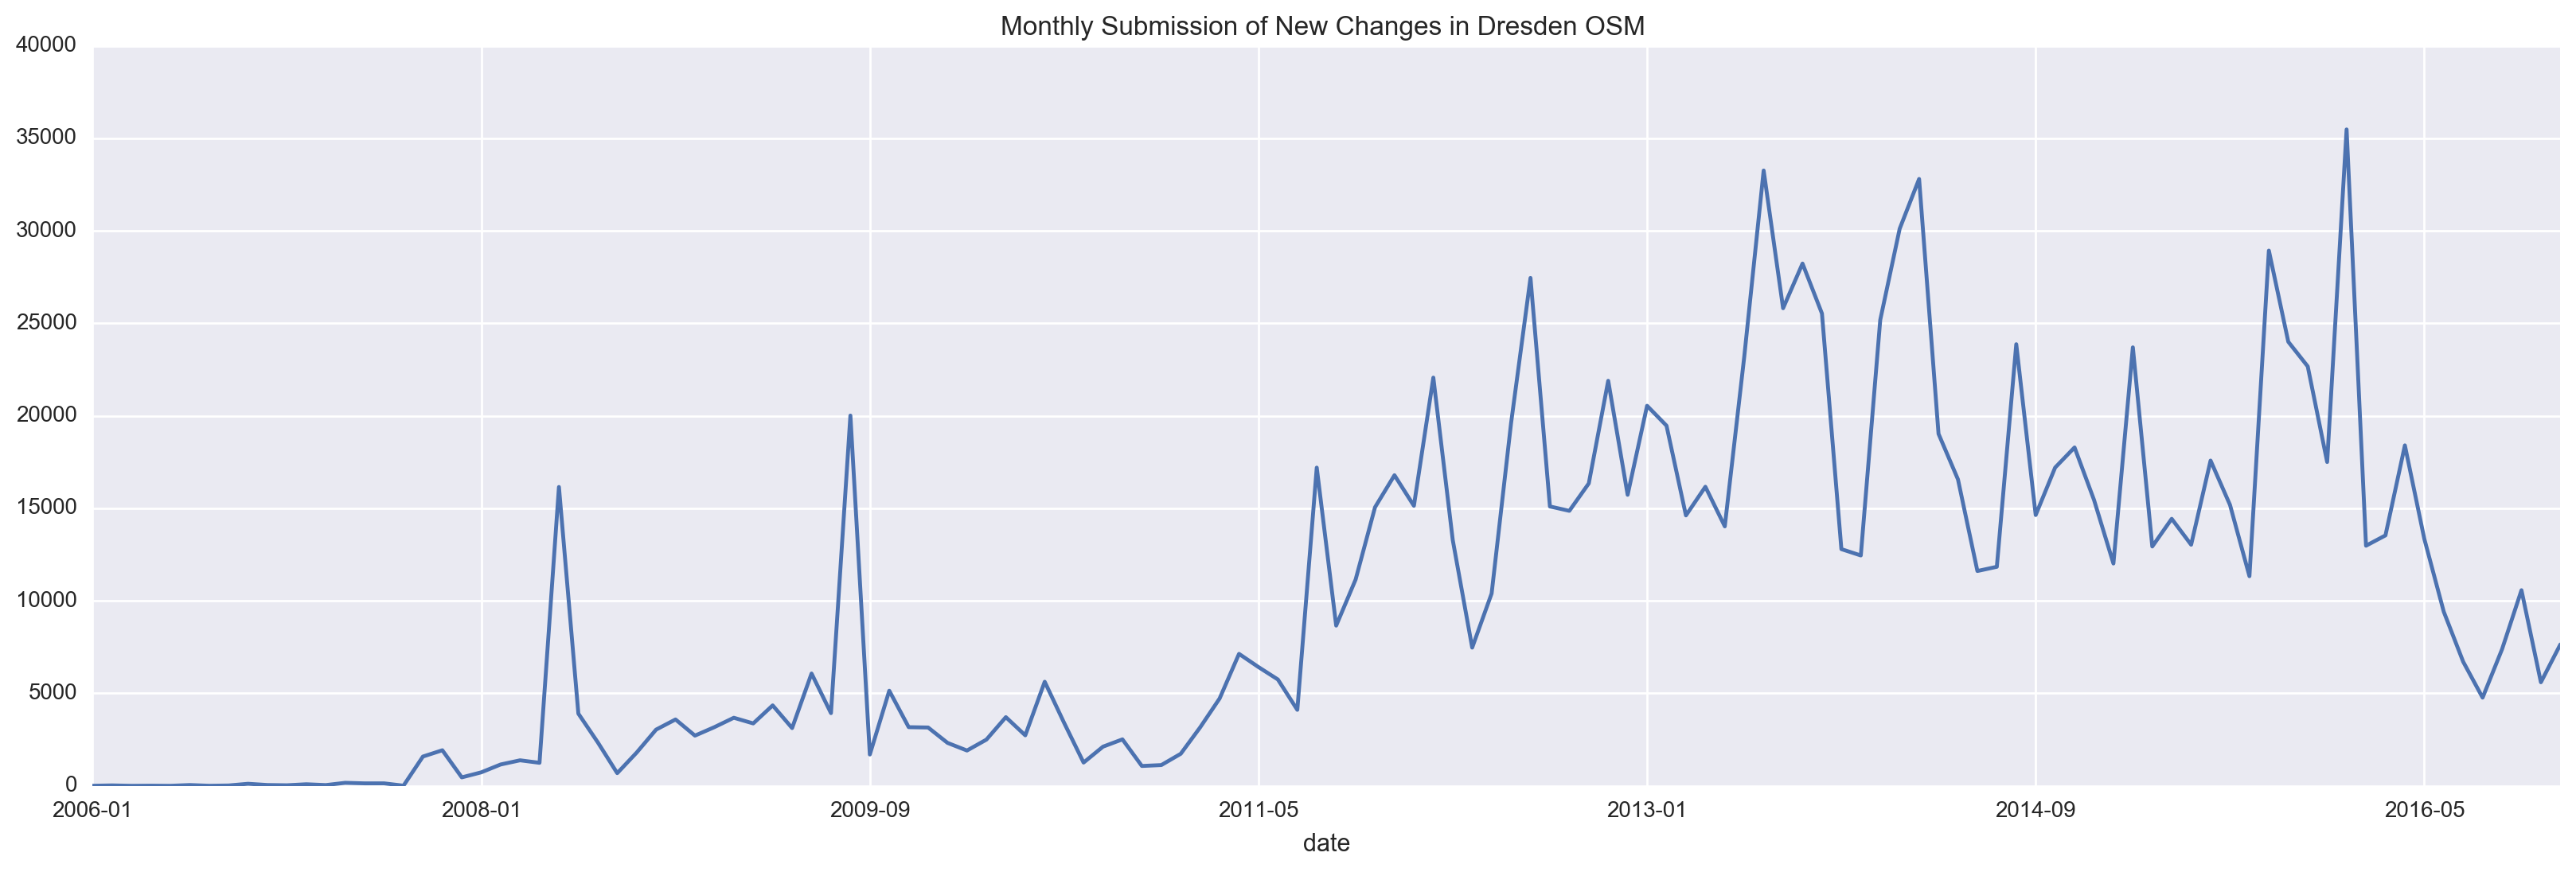

In [249]:
#生成每月更改提交量的走势图
data_df.groupby('date').count()['id'].plot(title='Monthly Submission of New Changes in Dresden OSM ',figsize=(20,6))


In [256]:
#列出月度提交量最高的5个时间
df = data_df.groupby('date',as_index=False).count()
df[df['id']>20000][['date','id']].sort_values(by='id',ascending=False).head()

,date,id
116,2016-01,35484
86,2013-07,33263
94,2014-03,32806
93,2014-02,30114
112,2015-09,28934


<span style='color:blue'>**以上走势图和数据表可以看出Dresden的数据更改提交量并不均衡，波动较大，每年都会有几个高峰，最高峰发生在2016年1月和2013年7月。另外，2016年1月的最高峰过后，提交量一路走低，甚至于达到了5年多来的最低点，要了解具体原因可能需要了解更多数据库以外的信息。**</span>

下面再看一下2016年1月的所有用户的提交量排名：

In [269]:
df2 = data_df.groupby(['date','user_name'], as_index=False).count()[['date','id','user_name']]
df2[df2['date']=='2016-01'].sort_values(by='id', ascending=False).head()

,date,id,user_name
5448,2016-01,17149,roschitom
5433,2016-01,4855,geri-oc
5422,2016-01,4416,Wolle DD
5394,2016-01,1505,Eisenspleiszer
5419,2016-01,1370,Thomas8122


发现2016年1月提交量最高的用户名为：<span style='color:blue'>roschitom</span>，提交量是17149，几乎是当月所有提交量的一半。通过mongo shell查询，其历史提交总量为34344.

```bash
> db.dresden.find({'created.user': "roschitom"}).count()
34344
```

In [354]:
query_ro = [
    { '$match': { 'created.user': 'roschitom' }},
    { '$group': { '_id': '$created.changeset',
                  'count': { '$sum': 1 } } },
    { '$sort' : { 'count' : -1 } }]
result_ro =  db.dresden.aggregate(query_ro)

In [355]:
result_ro_list = [x for x in result_ro]
print '列出用户roschitom 所有提交过的changeset记录中更改条目数量排TOP10的记录：'
for item in result_ro_list[:10]:
    line = db.dresden.find_one({'created.changeset': item['_id']},{'_id': 0, 'created.changeset': 1, 'created.user': 1, 'created.timestamp': 1})  
    print 'changeset:', line['created']['changeset'], '|', 'count:', item['count'], '|', 'date:', line['created']['timestamp'][:10]

列出用户roschitom 所有提交过的changeset记录中更改条目数量排TOP10的记录：
changeset: 36882155 | count: 2756 | date: 2016-01-29
changeset: 36643222 | count: 2591 | date: 2016-01-17
changeset: 36613509 | count: 1980 | date: 2016-01-16
changeset: 36595118 | count: 1931 | date: 2016-01-15
changeset: 39152546 | count: 1781 | date: 2016-05-06
changeset: 35602650 | count: 1723 | date: 2015-11-26
changeset: 36584469 | count: 1441 | date: 2016-01-15
changeset: 36577261 | count: 1287 | date: 2016-01-14
changeset: 36603872 | count: 1238 | date: 2016-01-15
changeset: 36625461 | count: 1175 | date: 2016-01-16


综上可以看出，用户roschitom大量的提交（特别是在2016年1月）数据量普遍较大，经过在mongo shell中选择其中几个changeset进行简单查询后发现这些数据相应的“node”基本被“way”类型的文档所引用，查阅OpenStreetMap的官方wiki页面(http://wiki.openstreetmap.org/wiki/Beginners_Guide_1.2.2)    了解到用户可以将GPS设备或者软件采集到的GPS数据log批量导入到OSM中，<span style='color:blue'>**因此可以基本确认，用户roschitom应该就是通过GPS数据log得以短时间内大量地上传了数据到OSM中**。</span>

## 5. 对于数据库其它的想法

OSM的用户指南中(http://wiki.openstreetmap.org/wiki/Good_changeset_comments)    建议用户在每一次的将数据集changeset上传网站时维护comment信息，即说明一下此次上传的更改的主要内容或者原因，以便于其他用户快速了解。<span style='color:blue'>那就让我们看看在Dresden数据库中用户是否都会填写comment：</span>

In [374]:
#查询所有存在key值为comment的文档数量
db_result_comment = db.dresden.find({'comment': {'$exists': 1}})
print '有comment的文档总数:', db_result_comment.count()
commented_user = [x['created']['user'] for x in db_result_comment]
user_name_comment = {}
for x in commented_user:
    user_name_comment[x] = user_name_comment.get(x, 0) + 1
pprint.pprint(user_name_comment)

有comment的文档总数: 106
{u'4b696d': 3,
 u'Aleks-Berlin': 1,
 u'Black-Eagle': 2,
 u'Eicca': 3,
 u'Eisenspleiszer': 1,
 u'Hedaja': 1,
 u'JGardke': 2,
 u'Jochen Topf': 1,
 u'Klumbumbus': 1,
 u'MKnight': 2,
 u'MaxF37': 2,
 u'Nordpfeil': 4,
 u'Skagen': 3,
 u'TEAM_CN_TUD': 3,
 u'Wall\xb7E': 1,
 u'Wolle DD': 1,
 u'avena701': 36,
 u'bigbug21': 1,
 u'burts': 7,
 u'ddgb': 2,
 u'ht_': 2,
 u'iknopf': 7,
 u'jacobbraeutigam': 5,
 u'kkokus': 1,
 u'kummeru': 1,
 u'mh_helge': 1,
 u'monotar': 1,
 u'scai': 5,
 u'stw1701': 2,
 u'theonlytruth': 1,
 u'ulmtuelp': 1,
 u'utack': 1,
 u'wheelmap_visitor': 1}


**有comment的文档只有106个，在整个数据库中的占比不足万分之一，可以想见，这样对于后续用户的持续优化改进是非常不利的，<span style='color:blue'>因此，OSM在这一点上可以进行改进，应该通过一些方法来鼓励用户提交comment信息，比如设置一些预置的comment选项，或者强制用户维护comment等方法。</span>**

### 实施改进后的收益和可能带来的问题

#### 收益
如果通过一些方法能促使用户更多的提交comment之后，将为后续用户对地图的持续优化提供很多便利，特别是在市中心等更新比较密集的区域，后来的用户在更新通过查看以往用户的comment可以了解以往的更新历史概况，以便用户决定是否进行更新以及如何更新，同时也能通过这种方式形成更好的社区互动氛围。

#### 风险
大量增加comment信息后，由于comment的信息一般是一段描述性的文字，其内容一般较长，因此可能会对数据库的容量带来一定的挑战，同时在用户读取或者下载地图数据时的网络数据传输量也会增加不少，这些问题时需要在实施改进时予以考虑的，比如在鼓励用户提交comment时同时限制comment内容的长度等等。